In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.24 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np
from agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
from numpy import savez_compressed

%matplotlib inline

env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
states = env_info.vector_observations
state_size = states.shape[1]
action_size = brain.vector_action_space_size
    
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def ddpg(n_episodes=1000, max_t=500, print_every=1, result_episode=100, threshold=30):
    mean_scores = []
    score_windows = deque(maxlen=100)
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(len(env_info.agents))
        agent.reset()
        for t in range(max_t):
            actions = agent.act(state=states, add_noise=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get reward (for each agent)
            for i in range(len(rewards)):
                rewards[i]=0.1 if env_info.rewards[i] > 0.0 else 0.0
            dones = env_info.local_done
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores = scores+rewards
            
            if np.any(dones):
                break
        
        mean_score = np.mean(scores)
        mean_scores.append(mean_score)
        score_windows.append(mean_score )
        savez_compressed('mean_scores.npz', mean_scores)
        
        print('\rEpisode {}\tAverage Score: {:.1f}'.format(i_episode, np.mean(score_windows)), end="")
        if len(score_windows) >= 100 and np.mean(score_windows) > threshold:
            print(f"\nEnvironment solved in {i_episode} episodes.")
            break
        
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_windows)))
            
    return mean_scores

Episode 0	Average Score: 1.60
Episode 1	Average Score: 1.66
Episode 2	Average Score: 1.91
Episode 3	Average Score: 2.23
Episode 4	Average Score: 2.30
Episode 5	Average Score: 2.71
Episode 6	Average Score: 3.22
Episode 7	Average Score: 3.53
Episode 8	Average Score: 3.92
Episode 9	Average Score: 4.22
Episode 10	Average Score: 4.39
Episode 11	Average Score: 4.64
Episode 12	Average Score: 4.97
Episode 13	Average Score: 5.33
Episode 14	Average Score: 5.61
Episode 15	Average Score: 5.83
Episode 16	Average Score: 6.04
Episode 17	Average Score: 6.32
Episode 18	Average Score: 6.57
Episode 19	Average Score: 6.83
Episode 20	Average Score: 7.13
Episode 21	Average Score: 7.45
Episode 22	Average Score: 7.88
Episode 23	Average Score: 8.32
Episode 24	Average Score: 8.56
Episode 25	Average Score: 8.93
Episode 26	Average Score: 9.18
Episode 27	Average Score: 9.38
Episode 28	Average Score: 9.63
Episode 29	Average Score: 9.88
Episode 30	Average Score: 10.11
Episode 31	Average Score: 10.28
Episode 32	Avera

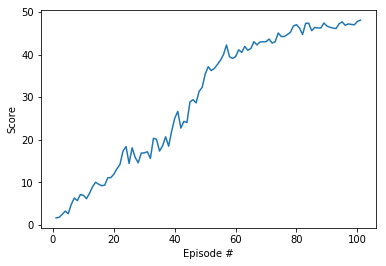

In [4]:
scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()